# Perform consensus sequence design

For results presented in Fig 2c

In [1]:
import os
import sys
import pickle
import copy
import random

from Bio import SeqIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf

from sklearn.manifold import MDS
from sklearn.decomposition import PCA

sys.path.append('../common')
import data_io_utils
import paths
import constants
import utils

import A009_common

%reload_ext autoreload
%autoreload 2

In [2]:
parent_names, parent_seqs = A009_common.fasta_read(
    '20181110_filtered_FPBase_Aequorea_FPs_candidates_for_synthesis_alignment_training_homologs_only.fasta')

In [3]:
enc_parent_seqs = np.stack([utils.encode_aa_seq_as_one_hot(s, flatten=False) for s in parent_seqs])
enc_parent_seqs.shape

(54, 20, 238)

In [4]:
parent_pwm = np.mean(enc_parent_seqs, axis=0)
print(parent_pwm.shape)

(20, 238)


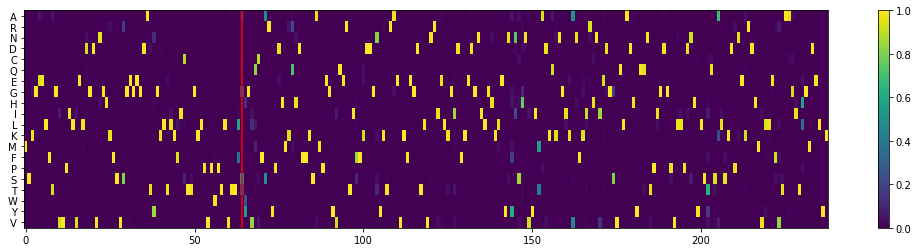

In [5]:
plt.figure(figsize=(18,4))
plt.imshow(parent_pwm, aspect='auto')
plt.colorbar()
plt.yticks(np.arange(len(constants.AA_ALPHABET_STANDARD_ORDER)))
plt.gca().set_yticklabels(list(constants.AA_ALPHABET_STANDARD_ORDER))
plt.axvline(64, color='r')
plt.show()

## Effective number of sequences

In [6]:
effective_aa = np.exp(-np.nansum(parent_pwm*np.log(parent_pwm), axis=0))
print(np.prod(effective_aa)/(10**12))

366.051405594624


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in multiply
  """Entry point for launching an IPython kernel.


366 trillion effective sequences.

## Generate a bunch of sequences and then take the ones with the best log-likelihoods.

We will do this with a metropolis hastings sampler to enrich for high probability sequences under our PWM.

In [7]:
def sample_random_seq_from_pwm(pwm):
    alphabet = list(constants.AA_ALPHABET_STANDARD_ORDER)
    aa_idx = np.array([np.random.choice(len(alphabet), 1, p=pwm[:,i].reshape(-1))[0] for i in range(pwm.shape[1])])

    seq = ''.join(list(np.array(alphabet)[aa_idx]))
    log_like = np.sum(np.log(pwm[aa_idx, np.arange(pwm.shape[1])]))
    
    return seq, log_like

def decode_top_seq(pwm):
    alp_arr = np.array(list(constants.AA_ALPHABET_STANDARD_ORDER))

    # Get sequence
    top_idx = np.argmax(pwm, axis=0)
    top_seq = ''.join(list(alp_arr[top_idx]))

    # Get log-likelihood
    col_idx = np.arange(pwm.shape[1])
    log_like = np.sum(np.log(pwm[top_idx, col_idx]))

    return top_seq, log_like, top_idx

def calc_seq_log_like(seq, pwm):
    aa_idx = utils.encode_seq_as_integer_array(seq).reshape(-1).astype(int)
    log_like = np.sum(np.log(pwm[aa_idx, np.arange(pwm.shape[1])]))
    
    return log_like

def make_mutation(seq, pwm, mutable_pos, effective_aa, pos_temp=1.0):
    current_aa_idx = utils.encode_seq_as_integer_array(seq).reshape(-1).astype(int)

    # Choose a position. Preferably one with a large number of effective amino acids
    # as mutating here should not generate large penalties in log-likelihood.
    eff_aa_at_mutable_pos = effective_aa[mutable_pos]
    pos_prob = np.exp(pos_temp*eff_aa_at_mutable_pos)
    pos_prob = pos_prob/np.sum(pos_prob)
    pos = np.random.choice(mutable_pos, 1, p=pos_prob)[0]
    
    # Choose an amino acid that is NOT the one we are currently
    # at.
    prob_vec = copy.deepcopy(pwm[:, pos]).reshape(-1)
    prob_vec[current_aa_idx[pos]] = 0
    prob_vec = prob_vec/np.sum(prob_vec)
    mut_aa = np.random.choice(list(constants.AA_ALPHABET_STANDARD_ORDER), 1, p=prob_vec)[0]

    new_seq = seq[:pos] + mut_aa + seq[(pos+1):]

    return new_seq
    
    

def metropolis_hastings_seq_sampler(init_seq, pwm, n_iter=1000, pos_temp=1.0):
    pwm = copy.deepcopy(pwm)
    seq = copy.deepcopy(init_seq)
    
    effective_aa = np.exp(-np.nansum(pwm*np.log(pwm), axis=0))
    mutable_pos = np.argwhere(effective_aa > 1.0).reshape(-1)
    log_like = calc_seq_log_like(seq, pwm)
    
    seqs = [seq]
    log_likes = [log_like]
    accepts = [True]
    for i in range(n_iter):
        proposed_seq = make_mutation(seq, pwm, mutable_pos, 
                effective_aa, pos_temp=pos_temp)
        proposed_log_like = calc_seq_log_like(proposed_seq, pwm)
        
        hastings_ratio = min(1.0, np.exp(proposed_log_like - log_like))
        
        if np.random.rand() < hastings_ratio: # accept
            seq = proposed_seq
            log_like = proposed_log_like
            accepts.append(True)
        else:
            accepts.append(False)
            
        seqs.append(seq)
        log_likes.append(log_like)
        
    return seqs, np.array(log_likes), np.array(accepts)
        
            
def extract_top_seqs_from_trajectory(seqs, log_likes, n):
    sdict = {seqs[i]: log_likes[i] for i in range(len(seqs))}
        
    useqs = list(sdict.keys())
    ull = np.array([sdict[s] for s in useqs])

    sidx = np.argsort(-ull)

    top_useqs = list(np.array(useqs)[sidx][:n])
    top_ull = ull[sidx][:n]
    
    return top_useqs, top_ull
    

In [8]:
top_seq, top_log_like, top_aa_idx = decode_top_seq(parent_pwm)

## Sample consensus designs using metropolis-hastings sampling

In [9]:
np.random.seed(1)
random.seed(1)

init_seqs = [top_seq, constants.AVGFP_AA_SEQ]
pos_temps = [1.0, 2.5, 5.0]

top_traj_seqs = []
top_traj_log_likes = []
for init_seq in init_seqs:
    for pos_temp in pos_temps:
        
        seqs, log_likes, accepts = metropolis_hastings_seq_sampler(init_seq, 
                parent_pwm, n_iter=30000, pos_temp=pos_temp)
        
        tts, ttll = extract_top_seqs_from_trajectory(seqs, log_likes, 100)
        
        print(np.mean(accepts))
        
        top_traj_seqs += tts
        top_traj_log_likes += list(ttll)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in multiply


0.24945835138828706
0.4782840571980934
0.5692143595213492
0.24355854804839838
0.4749508349721676
0.5757474750841639


In [10]:
print(len(top_traj_seqs))
print(len(top_traj_log_likes))

600
600


Do meta-extraction of top sequences.

In [11]:
final_top_traj_seqs, final_top_traj_log_likes = extract_top_seqs_from_trajectory(
        top_traj_seqs, top_traj_log_likes, 50)

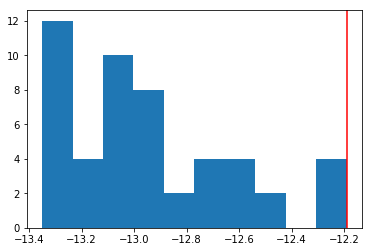

In [12]:
plt.hist(final_top_traj_log_likes, bins=10)
plt.axvline(top_log_like, color='r')
plt.show()

## Export

In [13]:
final_seqs = [top_seq] + final_top_traj_seqs
final_log_likes = np.array([top_log_like] + list(final_top_traj_log_likes))
ids = ['top_consensus_seq'] + ['sampled_consensus_seq_%d'%i for i in range(len(final_top_traj_seqs))]

Do a quick double check

In [14]:
for i,s in enumerate(final_seqs):
    assert calc_seq_log_like(s, parent_pwm) == final_log_likes[i]

In [15]:
df = pd.DataFrame()
df['id'] = ids
df['seq'] = final_seqs
df['log_likelihood'] = final_log_likes

df.drop_duplicates(subset='seq', keep='first', inplace=True)

df.head()

,id,seq,log_likelihood
0,top_consensus_seq,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,-12.190691
1,sampled_consensus_seq_0,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,-12.190691
3,sampled_consensus_seq_2,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,-12.304020
4,sampled_consensus_seq_3,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,-12.304020
5,sampled_consensus_seq_4,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,-12.500846


In [16]:
df.to_csv('GFP_consensus_seqs.csv', index=False)